In [6]:
# Step 1: Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import hopsworks
from hsfs.feature import Feature

from src.data_utils import load_and_process_citibike_data_from_local, transform_raw_data_into_ts_data
import src.config as config

In [9]:
# Step 2: Load Data from Local
print("📂 Loading Citi Bike data (2023)...")
data = load_and_process_citibike_data_from_local(
    year=2023,
    months=[1,2,3,4,5,6],
    base_path=config.LOCAL_CITIBIKE_DATA_PATH
)

📂 Loading Citi Bike data (2023)...


In [10]:
print("✅ Loaded data shape:", data.shape)
display(data.head())

✅ Loaded data shape: (165152, 14)


,ride_id,rideable_type,pickup_datetime,ended_at,start_station_name,pickup_location_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,source_file
0,A46D077151843D7B,classic_bike,2023-01-16 10:39:54.386,2023-01-16 10:45:18.005,West St & Chambers St,5329.03,West Thames St,5114.06,40.717548,-74.013221,40.708347,-74.017134,member,202301-citibike-tripdata_1.csv
1,233875BAED2E02D0,classic_bike,2023-01-12 16:55:30.755,2023-01-12 17:04:03.688,West St & Chambers St,5329.03,West Thames St,5114.06,40.717548,-74.013221,40.708347,-74.017134,member,202301-citibike-tripdata_1.csv
2,8DD222EA1A1B0BC9,electric_bike,2023-01-08 19:32:25.647,2023-01-08 19:42:00.382,West St & Chambers St,5329.03,West Thames St,5114.06,40.717618,-74.013071,40.708347,-74.017134,member,202301-citibike-tripdata_1.csv
3,58976A4F584F8D28,classic_bike,2023-01-27 20:01:52.897,2023-01-27 20:08:58.118,West St & Chambers St,5329.03,West Thames St,5114.06,40.717548,-74.013221,40.708347,-74.017134,member,202301-citibike-tripdata_1.csv
4,FDD4C1E89A26727C,classic_bike,2023-01-13 18:02:38.160,2023-01-13 18:11:22.139,West St & Chambers St,5329.03,West Thames St,5114.06,40.717548,-74.013221,40.708347,-74.017134,member,202301-citibike-tripdata_1.csv


In [11]:
# Step 3: Preprocess Data
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], errors="coerce")
data = data.dropna(subset=["pickup_datetime", "pickup_location_id"])
data["pickup_location_id"] = data["pickup_location_id"].astype(str)
data["pickup_hour"] = data["pickup_datetime"].dt.floor("h")

In [12]:
# Step 4: Transform into Hourly Time-Series
ts_data = transform_raw_data_into_ts_data(data)
print("✅ Transformed time-series shape:", ts_data.shape)
display(ts_data.head())

✅ Transformed time-series shape: (13287, 3)


,pickup_hour,pickup_location_id,rides
0,2022-12-28 11:00:00,5329.03,2
1,2022-12-28 12:00:00,5329.03,0
2,2022-12-28 13:00:00,5329.03,0
3,2022-12-28 14:00:00,5329.03,0
4,2022-12-28 15:00:00,5329.03,0


In [13]:
# Step 5: Check Aggregation Info
print("📅 Date range:", ts_data.pickup_hour.min(), "→", ts_data.pickup_hour.max())
print("🧠 Nulls present:")
display(ts_data.isnull().sum())

📅 Date range: 2022-12-28 11:00:00 → 2023-06-30 23:00:00
🧠 Nulls present:


pickup_hour           0
pickup_location_id    0
rides                 0
dtype: int64

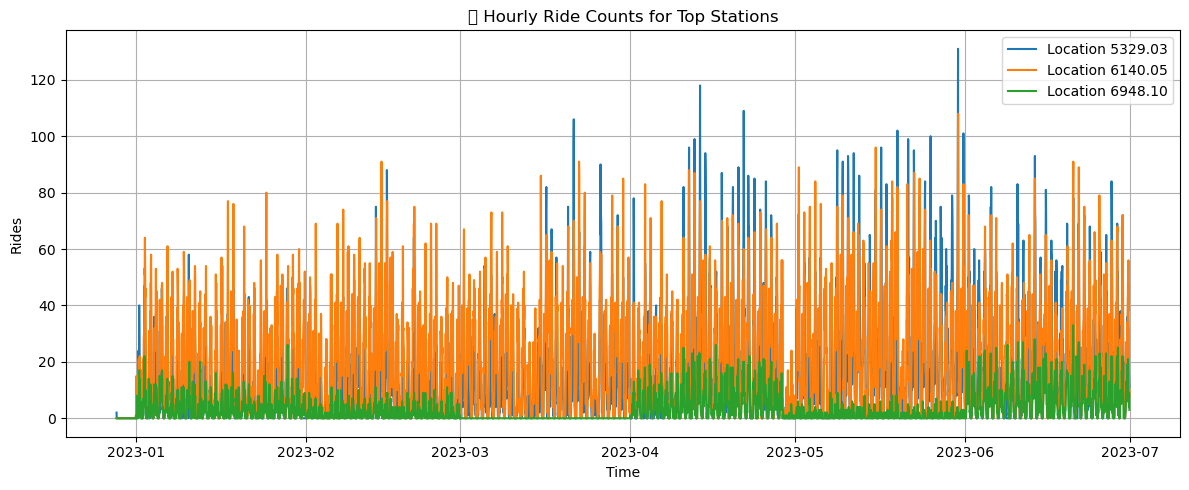

In [14]:
# Step 6: Visualize Time-Series
plt.figure(figsize=(12, 5))
for location_id in ts_data.pickup_location_id.unique():
    subset = ts_data[ts_data.pickup_location_id == location_id]
    plt.plot(subset.pickup_hour, subset.rides, label=f"Location {location_id}")
plt.legend()
plt.title("📈 Hourly Ride Counts for Top Stations")
plt.xlabel("Time")
plt.ylabel("Rides")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
csv_path = config.TRANSFORMED_DATA_DIR / "jan_jun_2023_ts_data.csv"
ts_data.to_csv(csv_path, index=False)
print(f"💾 Saved to: {csv_path}")

💾 Saved to: /Users/siddharthadhikari/github/bike_project/data/transformed/jan_jun_2023_ts_data.csv


In [16]:
# Step 8: Connect to Hopsworks and Register Feature Group
print("🔐 Logging in to Hopsworks ...")
project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME,
    api_key_value=config.HOPSWORKS_API_KEY
)
fs = project.get_feature_store()

🔐 Logging in to Hopsworks ...
2025-05-10 05:13:51,305 INFO: Initializing external client
2025-05-10 05:13:51,306 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 05:13:52,349 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1228966


In [17]:
# Define schema and feature group
schema = [
    Feature("pickup_hour", "timestamp"),
    Feature("pickup_location_id", "string"),
    Feature("rides", "int")
]

fg = fs.get_or_create_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION,
    description="Hourly Citi Bike rides (March 2023)",
    primary_key=["pickup_hour", "pickup_location_id"],
    event_time="pickup_hour",
    online_enabled=False,
    features=schema
)


In [18]:
# Cast dtypes and insert
print("📤 Writing to Hopsworks...")
ts_data["pickup_location_id"] = ts_data["pickup_location_id"].astype(str)
ts_data["rides"] = ts_data["rides"].astype("int32")
fg.insert(ts_data, write_options={"wait_for_job": True})
print("✅ Successfully registered with Hopsworks")


📤 Writing to Hopsworks...


Uploading Dataframe: 100.00% |█| Rows 13287/13287 | Elapsed Time: 00:02 | Remain


Launching job: citibike_hourly_features_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1228966/jobs/named/citibike_hourly_features_1_offline_fg_materialization/executions
2025-05-10 05:14:25,809 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-05-10 05:14:28,950 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-05-10 05:16:18,097 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-05-10 05:16:18,217 INFO: Waiting for log aggregation to finish.
2025-05-10 05:16:26,642 INFO: Execution finished successfully.
✅ Successfully registered with Hopsworks
